<a href="https://colab.research.google.com/github/cheneeheng/Transformer-TF/blob/colab_dev/Cifar10_VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR10 Classification**

Based on [CIFAR10_Keras_GPU.ipynb](https://github.com/katnoria/cifar10-native-vs-colab/blob/master/CIFAR10_Keras_GPU.ipynb) from [katnoria/cifar10-native-vs-colab](https://github.com/katnoria/cifar10-native-vs-colab) .

General info about the dataset:
- 50K Train, 10K Test
- 10 object classes


# Imports

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from time import time
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import tensorflow as tf
tf.__version__

'2.4.1'

# Data generator

In [2]:
from tensorflow.keras.datasets import cifar10

(x_trn_full, y_trn_full), (x_tst, y_tst) = cifar10.load_data()

# remove the last dimension
y_trn_full = y_trn_full.reshape(y_trn_full.shape[0],)
y_tst = y_tst.reshape(y_tst.shape[0],)

# perform in model.
# # normalize data to 0..1
# x_trn_full, x_tst = x_trn_full / 255.0, x_tst / 255.0

# create validation split
# split = 0.2
# x_trn, x_val, y_trn, y_val = train_test_split(
#     x_trn_full, y_trn_full, test_size=split, random_state=1969)
x_trn, x_val, y_trn, y_val = x_trn_full, x_tst, y_trn_full, y_tst

print(f'x_trn.shape: {x_trn.shape}')
print(f'y_trn.shape: {y_trn.shape}')
print(f'x_val.shape: {x_val.shape}')
print(f'y_val.shape: {y_val.shape}')
print(f'x_tst shape: {x_tst.shape}')
print(f'y_tst.shape: {y_tst.shape}')

x_trn.shape: (50000, 32, 32, 3)
y_trn.shape: (50000,)
x_val.shape: (10000, 32, 32, 3)
y_val.shape: (10000,)
x_tst shape: (10000, 32, 32, 3)
y_tst.shape: (10000,)


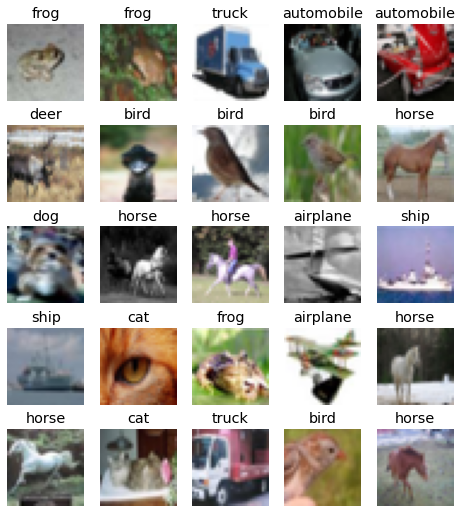

In [3]:
# pick 25 random images and plot
idxs = np.random.randint(x_trn.shape[0], size=25)
images = x_trn[idxs]
labels = y_trn[idxs]
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = labels[i]
  ax.set_title(classnames[idx])
plt.show()

In [4]:
class Patches(tf.keras.layers.Layer):
  """Creates patches from an image. Implemented as a keras layer."""
  def __init__(self, patch_size: int):
    super().__init__()
    self.patch_size = patch_size

  def call(self, x):
    batch_size = tf.shape(x)[0]
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

  def get_config(self):
    return {"patch_size": self.patch_size}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 48


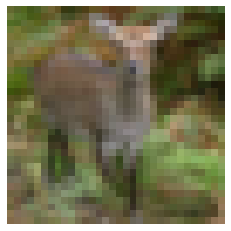

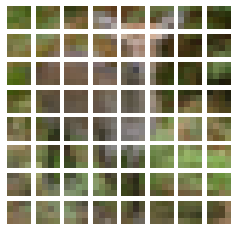

In [5]:
plt.figure(figsize=(4, 4))
image = x_trn[np.random.choice(range(x_trn.shape[0]))]
plt.imshow(image)
plt.axis("off")

image_size = 32
patch_size = 4

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [6]:
def data_generator(split: str, batch_size: int, shuffle_buffer: int = 10000):
  """Creates a tf.data.Dataset instance.

  Args:
      split: The type of data to generate, ['train', 'val', 'test'].
      batch_size: Batch size.
      shuffle_buffer: Number of elements used for shuffling.

  Returns:
      A tf.data.Dataset instance.

  Raises:
      ValueError: If `split` is not ['train', 'val', 'test'].

  """
  if split == 'train':
    ds = tf.data.Dataset.from_tensor_slices((x_trn, y_trn))
    ds = ds.shuffle(shuffle_buffer)
  elif split == 'val':
    ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  elif split == 'test':
    ds = tf.data.Dataset.from_tensor_slices((x_tst, y_tst))
  else:
    raise ValueError(f"Unknown data split : {split}")
  return ds.batch(batch_size)

# Model

A simple CNN example from the keras [CNN benchmark](https://github.com/keras-team/keras/blob/master/keras/benchmarks/keras_examples_benchmarks/cifar10_cnn_benchmark_test.py) .  
It is based on this [CNN example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) but the example is no longer available.


In [7]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Conv2D, 
  BatchNormalization, 
  MaxPool2D,
  Dropout,
  Flatten,
  Dense
)
from tensorflow.keras.initializers import TruncatedNormal, Constant, Zeros
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu
from tensorflow.keras.layers.experimental.preprocessing import (
  RandomFlip,
  RandomTranslation,
  RandomRotation,
  RandomZoom,
  Normalization,
  Rescaling,
  Resizing
)

def conv2d(filters, kernel_size, strides=(1, 1), padding='valid', **kwargs):
  return Conv2D(filters, 
                kernel_size, 
                strides, 
                padding=padding, 
                activation=relu,
                **kwargs)
  
def maxpool2d(**kwargs):
  return MaxPool2D([3, 3], 2, padding='valid', **kwargs)

class SmallCNN(Model):
  """SmallCNN implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """

  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               preprocess: bool = False):
    super().__init__()

    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Model
    self.conv1 = conv2d(32, 3, name='conv1', padding='same')
    self.conv2 = conv2d(32, 3, name='conv2')
    self.pool2 = maxpool2d(name='pool1')
    self.drop2 = Dropout(0.5, name='drop2')
    self.conv3 = conv2d(64, 3, name='conv3', padding='same')
    self.conv4 = conv2d(64, 3, name='conv4')
    self.pool4 = maxpool2d(name='pool4')
    self.drop4 = Dropout(0.25, name='drop4')
    self.flat5 = Flatten(name='flat5')
    self.dens5 = Dense(512, activation=relu, name='dens5')
    self.drop5 = Dropout(0.5, name='drop5')
    self.dens6 = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)
    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)
    x = self.pool2(self.conv2(self.conv1(x)))
    x = self.drop2(x, training=training)
    x = self.pool4(self.conv4(self.conv3(x)))
    x = self.drop4(x, training=training)
    x = self.dens5(self.flat5(x))
    x = self.drop5(x, training=training)
    x = self.dens6(x)
    return x
  
  # https://stackoverflow.com/questions/55235212
  def model(self):
    x = Input(shape=(32, 32, 3))
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
    return {"num_classes": self.num_classes,
            "image_height": self.image_height,
            "image_width": self.image_width,
            "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
    return cls(**config)

[Vision Transformer](https://arxiv.org/abs/2010.11929) by Alexey Dosovitskiy et al.  
Code taken from this [example](https://keras.io/examples/vision/image_classification_with_vision_transformer/) .

In [8]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Layer,
  Add,
  BatchNormalization, 
  Conv2D, 
  Dense,
  Dropout,
  Embedding,
  Flatten,
  LayerNormalization,
  MaxPool2D,
  MultiHeadAttention
)
from tensorflow.keras.initializers import TruncatedNormal, Constant, Zeros
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu, gelu
from tensorflow.keras.layers.experimental.preprocessing import (
  Normalization,
  RandomFlip,
  RandomRotation,
  RandomZoom,
  Rescaling,
  Resizing,
)

def mlp(hidden_units: list, dropout_rate: float, name: str = ''):
  """Multilayer perceptron."""
  layers = []
  for idx, units in enumerate(hidden_units):
    layers.append(Dense(units, activation=gelu, name=f'{name}/dens{idx}'))
    layers.append(Dropout(dropout_rate, name=f'{name}/drop{idx}'))
  return layers

class MLP(Layer):
  """Multilayer perceptron."""
  def __init__(self, hidden_units: list, dropout_rate: float):
    super().__init__()
    self.hidden_units = hidden_units
    self.dropout_rate = dropout_rate
    
    self.layers = []
    self.dropouts = []
    for idx, units in enumerate(self.hidden_units):
      self.layers.append(Dense(units, activation=gelu, name=f'dens{idx}'))
      self.dropouts.append(Dropout(dropout_rate))

  def call(self, x, training: bool = None):
    for layer_i, dropout_i in zip(self.layers, self.dropouts):
        x = layer_i(x)
        x = dropout_i(x, training=training)
    return x
  
  def get_config(self):
    return {"hidden_units": self.hidden_units,
            "dropout_rate": self.dropout_rate}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class PatchEncoder(Layer):
  """Encoder for the image patches."""
  def __init__(self, num_patches: int, projection_dim: int):
    super().__init__()
    self.num_patches = num_patches
    self.projection_dim = projection_dim
    self.projection = Dense(units=self.projection_dim)
    self.position_embedding = Embedding(input_dim=num_patches,
                                        output_dim=self.projection_dim)

  def call(self, x):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(x) + self.position_embedding(positions)
    return encoded
  
  def get_config(self):
    return {"num_patches": self.num_patches,
            "projection_dim": self.projection_dim}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class VIT(Model):
  """Vision Transformer implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """
  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               patch_size: int, 
               projection_dim: int,
               num_layers: int,
               num_heads: int,
               mlp_dims: list,
               classifier_mlp_dims: list,
               preprocess: bool = False):
    super().__init__()
    
    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.patch_size = patch_size
    self.projection_dim = projection_dim
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.mlp_dims = mlp_dims
    self.classifier_mlp_dims = classifier_mlp_dims
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Patches
    self.patch = Patches(self.patch_size)
    num_patches = (self.image_height // self.patch_size) * \
                  (self.image_width // self.patch_size)
    self.patch_enc = PatchEncoder(num_patches, self.projection_dim)

    # Model
    self.transformer_blocks = []
    for idx in range(self.num_layers):
      block = []
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_1')]
      block += [MultiHeadAttention(self.num_heads, 
                                   self.projection_dim, 
                                   dropout=0.1, 
                                   name=f'mha{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_1')]
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_2')]
      block += [mlp(mlp_dims, dropout_rate=0.1, name=f'mlp{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_2')]
      self.transformer_blocks.append(block)

    self.lnorm = LayerNormalization(epsilon=1e-6, name='classifier_ln')
    self.flat = Flatten(name='classifier_flat')
    self.drop = Dropout(0.5, name='classifier_drop')
    self.mlp = mlp(self.classifier_mlp_dims, dropout_rate=0.5, 
                   name='classifier_mlp')
    self.logits = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)

    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)

    x = self.patch(x)
    x = self.patch_enc(x)
    
    for block in self.transformer_blocks:
      x_layer_norm_1 = block[0](x)
      x_attention    = block[1](x_layer_norm_1, x_layer_norm_1)
      x_skip         = block[2]([x_attention, x])
      x_layer_norm_2 = block[3](x_skip)
      x_mlp          = self._iterate_mlp(block[4], x_layer_norm_2)
      x              = block[5]([x_mlp, x_skip])
    
    x = self.lnorm(x)
    x = self.flat(x)
    x = self.drop(x, training=training)
    x = self._iterate_mlp(self.mlp, x)
    x = self.logits(x)
    return x
  
  @staticmethod
  def _iterate_mlp(mlp_layers: list, x: tf.Tensor):
    _x = x
    for mlp_i in mlp_layers:
      _x = mlp_i(_x)
    return _x

  # https://stackoverflow.com/questions/55235212
  def model(self):
    x = Input(shape=(32, 32, 3))
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
      return {"num_classes": self.num_classes,
              "image_height": self.image_height,
              "image_width": self.image_width,
              "patch_size": self.patch_size,
              "projection_dim": self.projection_dim,
              "num_layers": self.num_layers,
              "num_heads": self.num_heads,
              "mlp_dims": self.mlp_dims,
              "classifier_mlp_dims": self.classifier_mlp_dims,
              "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

Save an initial copy of the weights.  
The weights will be used to initialize all the experiments, allowing for fair comparison.


In [9]:
# Saves a full copy of the model.
model_SmallCNN = SmallCNN(num_classes=10, 
                          image_height=32, 
                          image_width=32,
                          preprocess=False).model()
model_SmallCNN.save('model_SmallCNN')

# Loads model
model_SmallCNN = tf.keras.models.load_model('model_SmallCNN')
model_SmallCNN.summary()

# Saves a full copy of the model.
model_VIT = VIT(num_classes=10, 
                image_height=32, 
                image_width=32,
                patch_size=4, 
                projection_dim=64,
                num_layers=4,
                num_heads=4,
                mlp_dims=[128, 64],
                classifier_mlp_dims=[512, 256],
                preprocess=False).model()
model_VIT.save('model_VIT')

# Loads model
model_VIT = tf.keras.models.load_model('model_VIT')
model_VIT.summary()

# # Saves only the weights of the model.
# model = SmallCNN(num_classes=10)
# model(tf.zeros([1,32,32,3]))
# model.save_weights('model.h5')

# # Loads weights
# model.load_weights('model.h5')
# model.preprocess = True
# for layer in model.model().layers:
#   print(layer.output)
# model.model().summary()

INFO:tensorflow:Assets written to: model_SmallCNN/assets
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop

INFO:tensorflow:Assets written to: model_VIT/assets


INFO:tensorflow:Assets written to: model_VIT/assets


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 48)     0           resize[0][0]                     
____________________________________________________________________________________________

# Train

Training configs.

In [10]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc_metric_fn = tf.keras.metrics.SparseCategoricalAccuracy
batch_size = 512
shuffle_buffer = 50000
epochs = 50
learning_rate = 1e-3

Keras model.compile(...) and model.fit(...) .


In [11]:
def train_and_eval(_model, _checkpoint_filepath):
  """Wrapper code for training and evaluating.

  Args:
      _model: A keras Model.
      _checkpoint_filepath: Path to save a checkpoint.

  Returns:
      A history instance that contains logged values per epoch.

  """
  _model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=loss_fn,
      metrics=[acc_metric_fn(name='sparse_categorical_accuracy')]
  )
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      _checkpoint_filepath,
      monitor="val_sparse_categorical_accuracy",
      save_best_only=True,
  )
  start = time()
  history = _model.fit(
      data_generator('train', batch_size, shuffle_buffer), 
      epochs=epochs, 
      steps_per_epoch=len(data_generator('train', batch_size, shuffle_buffer)),
      validation_data=data_generator('val', batch_size),
      callbacks=[checkpoint_callback],
  )
  end = time()
  print(f'Total training time {end - start} seconds')
  return history

Native TF with GradientTape.  
This is exactly the same as using compite(...) and fit(...) in keras.  
However, this exposes the gradient and the train loop, allowing for more flexibility.

In [12]:
%%script false
# This is just for reference.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = acc_metric_fn(name='sparse_categorical_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = acc_metric_fn(name='val_sparse_categorical_accuracy')

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_fn(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  # Container to keep the results.
  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def val_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  v_loss = loss_fn(labels, predictions)
  # Container to keep the results.
  val_loss(v_loss)
  val_accuracy(labels, predictions)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
progbar = tf.keras.utils.Progbar
trn_ds = data_generator('train', batch_size, shuffle_buffer)
val_ds = data_generator('val', batch_size)

start = time()
for epoch in range(epochs):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  print(f"Epoch {epoch+1}/{epochs}")
  pb_i = progbar(steps_per_epoch=len(trn_ds), 
                 stateful_metrics=['Loss', 'Accuracy',
                                   'Val Loss', 'Val Accuracy'])
  
  for idx, (images, labels) in enumerate(trn_ds):
    train_step(images, labels)
    if idx + 1 < mini_batches:
      pb_i.add(1, values=[('Loss', train_loss.result()), 
                          ('Accuracy', train_accuracy.result())])

  for val_images, val_labels in val_ds:
    val_step(val_images, val_labels)
  pb_i.add(1, values=[('Loss', train_loss.result()), 
                      ('Accuracy', train_accuracy.result()),
                      ('Val Loss', val_loss.result()), 
                      ('Val Accuracy', val_accuracy.result())])

  train_losses.append(train_loss.result())
  train_accuracies.append(train_accuracy.result())
  val_losses.append(val_loss.result())
  val_accuracies.append(val_accuracy.result())

end = time()

print(f'Total training time {end - start} seconds')

**Experiment 2**  
Model : VIT  
Preprocessing : False  
Batch size : 512

In [13]:
model_VIT = tf.keras.models.load_model('model_VIT')
model_VIT.summary()
history_vit_bs512 = train_and_eval(model_VIT, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 48)     0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 2/50
98/98 [==============================] - 13s 137ms/step - loss: 2.1729 - sparse_categorical_accuracy: 0.1601 - val_loss: 1.9608 - val_sparse_categorical_accuracy: 0.2518


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 3/50
98/98 [==============================] - 13s 136ms/step - loss: 2.0554 - sparse_categorical_accuracy: 0.2005 - val_loss: 1.8758 - val_sparse_categorical_accuracy: 0.2644


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 4/50
98/98 [==============================] - 14s 137ms/step - loss: 1.9389 - sparse_categorical_accuracy: 0.2437 - val_loss: 1.7932 - val_sparse_categorical_accuracy: 0.3179


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 5/50
98/98 [==============================] - 14s 137ms/step - loss: 1.8318 - sparse_categorical_accuracy: 0.2807 - val_loss: 1.6824 - val_sparse_categorical_accuracy: 0.3640


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 6/50
98/98 [==============================] - 14s 137ms/step - loss: 1.7520 - sparse_categorical_accuracy: 0.3213 - val_loss: 1.6430 - val_sparse_categorical_accuracy: 0.3776


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 7/50
98/98 [==============================] - 14s 137ms/step - loss: 1.6979 - sparse_categorical_accuracy: 0.3492 - val_loss: 1.5918 - val_sparse_categorical_accuracy: 0.4034


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 8/50
98/98 [==============================] - 14s 137ms/step - loss: 1.6291 - sparse_categorical_accuracy: 0.3862 - val_loss: 1.5719 - val_sparse_categorical_accuracy: 0.4241


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 9/50
98/98 [==============================] - 14s 137ms/step - loss: 1.5618 - sparse_categorical_accuracy: 0.4185 - val_loss: 1.4637 - val_sparse_categorical_accuracy: 0.4886


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 10/50
98/98 [==============================] - 14s 137ms/step - loss: 1.4966 - sparse_categorical_accuracy: 0.4446 - val_loss: 1.4015 - val_sparse_categorical_accuracy: 0.5049


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 11/50
98/98 [==============================] - 14s 138ms/step - loss: 1.4466 - sparse_categorical_accuracy: 0.4711 - val_loss: 1.3773 - val_sparse_categorical_accuracy: 0.5135


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 12/50
98/98 [==============================] - 14s 138ms/step - loss: 1.4137 - sparse_categorical_accuracy: 0.4849 - val_loss: 1.3222 - val_sparse_categorical_accuracy: 0.5389


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 13/50
98/98 [==============================] - 14s 138ms/step - loss: 1.3474 - sparse_categorical_accuracy: 0.5161 - val_loss: 1.3036 - val_sparse_categorical_accuracy: 0.5491


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 14/50
98/98 [==============================] - 14s 138ms/step - loss: 1.3083 - sparse_categorical_accuracy: 0.5290 - val_loss: 1.2483 - val_sparse_categorical_accuracy: 0.5644


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 15/50
98/98 [==============================] - 14s 138ms/step - loss: 1.2673 - sparse_categorical_accuracy: 0.5445 - val_loss: 1.2476 - val_sparse_categorical_accuracy: 0.5621
Epoch 16/50
98/98 [==============================] - 14s 138ms/step - loss: 1.2456 - sparse_categorical_accuracy: 0.5537 - val_loss: 1.2184 - val_sparse_categorical_accuracy: 0.5770


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 17/50
98/98 [==============================] - 14s 138ms/step - loss: 1.1964 - sparse_categorical_accuracy: 0.5729 - val_loss: 1.1697 - val_sparse_categorical_accuracy: 0.5906


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 18/50
98/98 [==============================] - 14s 138ms/step - loss: 1.1732 - sparse_categorical_accuracy: 0.5802 - val_loss: 1.1149 - val_sparse_categorical_accuracy: 0.6045


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 19/50
98/98 [==============================] - 14s 138ms/step - loss: 1.1170 - sparse_categorical_accuracy: 0.5977 - val_loss: 1.1128 - val_sparse_categorical_accuracy: 0.6035
Epoch 20/50
98/98 [==============================] - 14s 138ms/step - loss: 1.0893 - sparse_categorical_accuracy: 0.6111 - val_loss: 1.0912 - val_sparse_categorical_accuracy: 0.6006
Epoch 21/50
98/98 [==============================] - 14s 139ms/step - loss: 1.0583 - sparse_categorical_accuracy: 0.6214 - val_loss: 1.0917 - val_sparse_categorical_accuracy: 0.6113


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 22/50
98/98 [==============================] - 14s 139ms/step - loss: 1.0248 - sparse_categorical_accuracy: 0.6318 - val_loss: 1.0327 - val_sparse_categorical_accuracy: 0.6339


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 23/50
98/98 [==============================] - 14s 138ms/step - loss: 0.9879 - sparse_categorical_accuracy: 0.6503 - val_loss: 1.0291 - val_sparse_categorical_accuracy: 0.6401


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 24/50
98/98 [==============================] - 14s 138ms/step - loss: 0.9662 - sparse_categorical_accuracy: 0.6584 - val_loss: 1.0081 - val_sparse_categorical_accuracy: 0.6426


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 25/50
98/98 [==============================] - 14s 138ms/step - loss: 0.9354 - sparse_categorical_accuracy: 0.6691 - val_loss: 1.0011 - val_sparse_categorical_accuracy: 0.6452


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 26/50
98/98 [==============================] - 14s 138ms/step - loss: 0.9336 - sparse_categorical_accuracy: 0.6671 - val_loss: 0.9780 - val_sparse_categorical_accuracy: 0.6556


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 27/50
98/98 [==============================] - 14s 138ms/step - loss: 0.8885 - sparse_categorical_accuracy: 0.6838 - val_loss: 0.9731 - val_sparse_categorical_accuracy: 0.6579


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 28/50
98/98 [==============================] - 14s 139ms/step - loss: 0.8751 - sparse_categorical_accuracy: 0.6885 - val_loss: 0.9524 - val_sparse_categorical_accuracy: 0.6621


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 29/50
98/98 [==============================] - 14s 138ms/step - loss: 0.8537 - sparse_categorical_accuracy: 0.6944 - val_loss: 0.9576 - val_sparse_categorical_accuracy: 0.6651


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 30/50
98/98 [==============================] - 14s 138ms/step - loss: 0.8320 - sparse_categorical_accuracy: 0.7039 - val_loss: 0.9622 - val_sparse_categorical_accuracy: 0.6610
Epoch 31/50
98/98 [==============================] - 14s 138ms/step - loss: 0.8146 - sparse_categorical_accuracy: 0.7071 - val_loss: 0.9572 - val_sparse_categorical_accuracy: 0.6700


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 32/50
98/98 [==============================] - 14s 138ms/step - loss: 0.7885 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.9379 - val_sparse_categorical_accuracy: 0.6753


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 33/50
98/98 [==============================] - 14s 139ms/step - loss: 0.7581 - sparse_categorical_accuracy: 0.7295 - val_loss: 0.9262 - val_sparse_categorical_accuracy: 0.6756


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 34/50
98/98 [==============================] - 14s 141ms/step - loss: 0.7463 - sparse_categorical_accuracy: 0.7368 - val_loss: 0.9944 - val_sparse_categorical_accuracy: 0.6700
Epoch 35/50
98/98 [==============================] - 14s 140ms/step - loss: 0.7334 - sparse_categorical_accuracy: 0.7378 - val_loss: 0.9120 - val_sparse_categorical_accuracy: 0.6869


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 36/50
98/98 [==============================] - 14s 140ms/step - loss: 0.7104 - sparse_categorical_accuracy: 0.7462 - val_loss: 0.9174 - val_sparse_categorical_accuracy: 0.6851
Epoch 37/50
98/98 [==============================] - 14s 140ms/step - loss: 0.7031 - sparse_categorical_accuracy: 0.7463 - val_loss: 0.9300 - val_sparse_categorical_accuracy: 0.6850
Epoch 38/50
98/98 [==============================] - 14s 140ms/step - loss: 0.6767 - sparse_categorical_accuracy: 0.7575 - val_loss: 0.9211 - val_sparse_categorical_accuracy: 0.6859
Epoch 39/50
98/98 [==============================] - 14s 140ms/step - loss: 0.6597 - sparse_categorical_accuracy: 0.7621 - val_loss: 0.9029 - val_sparse_categorical_accuracy: 0.6925


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 40/50
98/98 [==============================] - 14s 140ms/step - loss: 0.6425 - sparse_categorical_accuracy: 0.7706 - val_loss: 0.9330 - val_sparse_categorical_accuracy: 0.6900
Epoch 41/50
98/98 [==============================] - 14s 140ms/step - loss: 0.6427 - sparse_categorical_accuracy: 0.7718 - val_loss: 0.9245 - val_sparse_categorical_accuracy: 0.6912
Epoch 42/50
98/98 [==============================] - 14s 140ms/step - loss: 0.6154 - sparse_categorical_accuracy: 0.7785 - val_loss: 0.9296 - val_sparse_categorical_accuracy: 0.6926


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 43/50
98/98 [==============================] - 14s 139ms/step - loss: 0.6045 - sparse_categorical_accuracy: 0.7819 - val_loss: 0.9075 - val_sparse_categorical_accuracy: 0.6965


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 44/50
98/98 [==============================] - 14s 139ms/step - loss: 0.5891 - sparse_categorical_accuracy: 0.7904 - val_loss: 0.9155 - val_sparse_categorical_accuracy: 0.7029


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 45/50
98/98 [==============================] - 14s 139ms/step - loss: 0.5732 - sparse_categorical_accuracy: 0.7929 - val_loss: 0.9063 - val_sparse_categorical_accuracy: 0.7068


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_VIT_210318/assets


Epoch 46/50
98/98 [==============================] - 14s 139ms/step - loss: 0.5663 - sparse_categorical_accuracy: 0.7961 - val_loss: 0.9188 - val_sparse_categorical_accuracy: 0.6998
Epoch 47/50
98/98 [==============================] - 14s 139ms/step - loss: 0.5518 - sparse_categorical_accuracy: 0.8037 - val_loss: 0.9157 - val_sparse_categorical_accuracy: 0.7022
Epoch 48/50
98/98 [==============================] - 14s 140ms/step - loss: 0.5533 - sparse_categorical_accuracy: 0.8018 - val_loss: 0.9082 - val_sparse_categorical_accuracy: 0.7046
Epoch 49/50
98/98 [==============================] - 14s 140ms/step - loss: 0.5360 - sparse_categorical_accuracy: 0.8069 - val_loss: 0.9462 - val_sparse_categorical_accuracy: 0.6999
Epoch 50/50
98/98 [==============================] - 14s 140ms/step - loss: 0.5229 - sparse_categorical_accuracy: 0.8123 - val_loss: 0.9337 - val_sparse_categorical_accuracy: 0.6991
Total training time 931.0499205589294 seconds


**Experiment 1**  
Model : CNN  
Preprocessing : False  
Batch size : 512

In [14]:
model_SmallCNN = tf.keras.models.load_model('model_SmallCNN')
model_SmallCNN.summary()
history_cnn_bs512 = train_and_eval(model_SmallCNN, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropout)              (None, 14, 14, 32)        0     

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 2/50
98/98 [==============================] - 3s 33ms/step - loss: 1.5668 - sparse_categorical_accuracy: 0.4256 - val_loss: 1.3748 - val_sparse_categorical_accuracy: 0.5007
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 3/50
98/98 [==============================] - 3s 33ms/step - loss: 1.3821 - sparse_categorical_accuracy: 0.4975 - val_loss: 1.2228 - val_sparse_categorical_accuracy: 0.5635
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 4/50
98/98 [==============================] - 3s 33ms/step - loss: 1.2582 - sparse_categorical_accuracy: 0.5495 - val_loss: 1.1054 - val_sparse_categorical_accuracy: 0.6107
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 5/50
98/98 [==============================] - 3s 33ms/step - loss: 1.1658 - sparse_categorical_accuracy: 0.5850 - val_loss: 1.0242 - val_sparse_categorical_accuracy: 0.6383
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 6/50
98/98 [==============================] - 3s 33ms/step - loss: 1.0970 - sparse_categorical_accuracy: 0.6135 - val_loss: 0.9655 - val_sparse_categorical_accuracy: 0.6603
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 7/50
98/98 [==============================] - 3s 34ms/step - loss: 1.0244 - sparse_categorical_accuracy: 0.6354 - val_loss: 0.9090 - val_sparse_categorical_accuracy: 0.6832
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 8/50
98/98 [==============================] - 3s 33ms/step - loss: 0.9765 - sparse_categorical_accuracy: 0.6507 - val_loss: 0.8599 - val_sparse_categorical_accuracy: 0.6986
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 9/50
98/98 [==============================] - 3s 33ms/step - loss: 0.9275 - sparse_categorical_accuracy: 0.6767 - val_loss: 0.8281 - val_sparse_categorical_accuracy: 0.7091
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 10/50
98/98 [==============================] - 3s 33ms/step - loss: 0.8931 - sparse_categorical_accuracy: 0.6850 - val_loss: 0.8113 - val_sparse_categorical_accuracy: 0.7200
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 11/50
98/98 [==============================] - 3s 33ms/step - loss: 0.8599 - sparse_categorical_accuracy: 0.6987 - val_loss: 0.7852 - val_sparse_categorical_accuracy: 0.7275
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 12/50
98/98 [==============================] - 3s 33ms/step - loss: 0.8303 - sparse_categorical_accuracy: 0.7063 - val_loss: 0.7412 - val_sparse_categorical_accuracy: 0.7464
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 13/50
98/98 [==============================] - 3s 33ms/step - loss: 0.7917 - sparse_categorical_accuracy: 0.7244 - val_loss: 0.7193 - val_sparse_categorical_accuracy: 0.7513
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 14/50
98/98 [==============================] - 3s 33ms/step - loss: 0.7796 - sparse_categorical_accuracy: 0.7277 - val_loss: 0.7128 - val_sparse_categorical_accuracy: 0.7486
Epoch 15/50
98/98 [==============================] - 3s 33ms/step - loss: 0.7607 - sparse_categorical_accuracy: 0.7329 - val_loss: 0.7235 - val_sparse_categorical_accuracy: 0.7514
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 16/50
98/98 [==============================] - 3s 33ms/step - loss: 0.7429 - sparse_categorical_accuracy: 0.7389 - val_loss: 0.6978 - val_sparse_categorical_accuracy: 0.7627
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 17/50
98/98 [==============================] - 3s 33ms/step - loss: 0.7203 - sparse_categorical_accuracy: 0.7468 - val_loss: 0.6827 - val_sparse_categorical_accuracy: 0.7690
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 18/50
98/98 [==============================] - 3s 33ms/step - loss: 0.7131 - sparse_categorical_accuracy: 0.7518 - val_loss: 0.6701 - val_sparse_categorical_accuracy: 0.7684
Epoch 19/50
98/98 [==============================] - 3s 33ms/step - loss: 0.6931 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.6787 - val_sparse_categorical_accuracy: 0.7682
Epoch 20/50
98/98 [==============================] - 3s 33ms/step - loss: 0.6829 - sparse_categorical_accuracy: 0.7611 - val_loss: 0.6526 - val_sparse_categorical_accuracy: 0.7753
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 21/50
98/98 [==============================] - 3s 33ms/step - loss: 0.6609 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.6543 - val_sparse_categorical_accuracy: 0.7769
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 22/50
98/98 [==============================] - 3s 33ms/step - loss: 0.6439 - sparse_categorical_accuracy: 0.7711 - val_loss: 0.6489 - val_sparse_categorical_accuracy: 0.7762
Epoch 23/50
98/98 [==============================] - 3s 33ms/step - loss: 0.6330 - sparse_categorical_accuracy: 0.7779 - val_loss: 0.6438 - val_sparse_categorical_accuracy: 0.7772
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 24/50
98/98 [==============================] - 3s 34ms/step - loss: 0.6292 - sparse_categorical_accuracy: 0.7773 - val_loss: 0.6296 - val_sparse_categorical_accuracy: 0.7863
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 25/50
98/98 [==============================] - 3s 33ms/step - loss: 0.6081 - sparse_categorical_accuracy: 0.7846 - val_loss: 0.6313 - val_sparse_categorical_accuracy: 0.7835
Epoch 26/50
98/98 [==============================] - 3s 33ms/step - loss: 0.6056 - sparse_categorical_accuracy: 0.7874 - val_loss: 0.6448 - val_sparse_categorical_accuracy: 0.7839
Epoch 27/50
98/98 [==============================] - 3s 33ms/step - loss: 0.6010 - sparse_categorical_accuracy: 0.7895 - val_loss: 0.6189 - val_sparse_categorical_accuracy: 0.7882
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 28/50
98/98 [==============================] - 3s 33ms/step - loss: 0.5764 - sparse_categorical_accuracy: 0.7971 - val_loss: 0.6268 - val_sparse_categorical_accuracy: 0.7863
Epoch 29/50
98/98 [==============================] - 3s 33ms/step - loss: 0.5801 - sparse_categorical_accuracy: 0.7931 - val_loss: 0.6112 - val_sparse_categorical_accuracy: 0.7934
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 30/50
98/98 [==============================] - 3s 33ms/step - loss: 0.5690 - sparse_categorical_accuracy: 0.8001 - val_loss: 0.6008 - val_sparse_categorical_accuracy: 0.7940
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 31/50
98/98 [==============================] - 3s 33ms/step - loss: 0.5615 - sparse_categorical_accuracy: 0.8007 - val_loss: 0.5869 - val_sparse_categorical_accuracy: 0.7993
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 32/50
98/98 [==============================] - 3s 33ms/step - loss: 0.5436 - sparse_categorical_accuracy: 0.8075 - val_loss: 0.6054 - val_sparse_categorical_accuracy: 0.7923
Epoch 33/50
98/98 [==============================] - 3s 33ms/step - loss: 0.5378 - sparse_categorical_accuracy: 0.8112 - val_loss: 0.5885 - val_sparse_categorical_accuracy: 0.7984
Epoch 34/50
98/98 [==============================] - 3s 33ms/step - loss: 0.5382 - sparse_categorical_accuracy: 0.8095 - val_loss: 0.5994 - val_sparse_categorical_accuracy: 0.7955
Epoch 35/50
98/98 [==============================] - 3s 33ms/step - loss: 0.5307 - sparse_categorical_accuracy: 0.8126 - val_loss: 0.5924 - val_sparse_categorical_accuracy: 0.7985
Epoch 36/50
98/98 [==============================] - 3s 33ms/step - loss: 0.5169 - sparse_categorical_accuracy: 0.8175 - val_loss: 0.5992 - val_sparse_categorical_accuracy: 0.7922
Epoch 37/50
98/98 [==============================] - 3s 33ms/step - loss: 0.5209 - sparse_categorica

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 38/50
98/98 [==============================] - 3s 33ms/step - loss: 0.4988 - sparse_categorical_accuracy: 0.8235 - val_loss: 0.6063 - val_sparse_categorical_accuracy: 0.7924
Epoch 39/50
98/98 [==============================] - 3s 33ms/step - loss: 0.4907 - sparse_categorical_accuracy: 0.8283 - val_loss: 0.5817 - val_sparse_categorical_accuracy: 0.8032
Epoch 40/50
98/98 [==============================] - 3s 33ms/step - loss: 0.4960 - sparse_categorical_accuracy: 0.8204 - val_loss: 0.5938 - val_sparse_categorical_accuracy: 0.7998
Epoch 41/50
98/98 [==============================] - 3s 33ms/step - loss: 0.4894 - sparse_categorical_accuracy: 0.8261 - val_loss: 0.5788 - val_sparse_categorical_accuracy: 0.8036
Epoch 42/50
98/98 [==============================] - 3s 33ms/step - loss: 0.4784 - sparse_categorical_accuracy: 0.8296 - val_loss: 0.5796 - val_sparse_categorical_accuracy: 0.8035
Epoch 43/50
98/98 [==============================] - 3s 33ms/step - loss: 0.4736 - sparse_categorica

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 45/50
98/98 [==============================] - 3s 34ms/step - loss: 0.4603 - sparse_categorical_accuracy: 0.8355 - val_loss: 0.5736 - val_sparse_categorical_accuracy: 0.8074
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 46/50
98/98 [==============================] - 3s 33ms/step - loss: 0.4552 - sparse_categorical_accuracy: 0.8364 - val_loss: 0.5936 - val_sparse_categorical_accuracy: 0.8034
Epoch 47/50
98/98 [==============================] - 3s 33ms/step - loss: 0.4554 - sparse_categorical_accuracy: 0.8354 - val_loss: 0.5800 - val_sparse_categorical_accuracy: 0.8051
Epoch 48/50
98/98 [==============================] - 3s 33ms/step - loss: 0.4516 - sparse_categorical_accuracy: 0.8404 - val_loss: 0.5699 - val_sparse_categorical_accuracy: 0.8099
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/Cifar10_CNN_210318/assets


Epoch 49/50
98/98 [==============================] - 3s 33ms/step - loss: 0.4547 - sparse_categorical_accuracy: 0.8384 - val_loss: 0.5778 - val_sparse_categorical_accuracy: 0.8061
Epoch 50/50
98/98 [==============================] - 3s 33ms/step - loss: 0.4395 - sparse_categorical_accuracy: 0.8431 - val_loss: 0.5793 - val_sparse_categorical_accuracy: 0.8059
Total training time 236.0085940361023 seconds


# Loss and accuracy plots

In [15]:
def plot(losses: list, accuracies: list, legend_labels: list, subplot_title: list):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
  
  for x, ll in zip(losses, legend_labels):
    ax1.plot(x, label=ll)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])
  ax1.legend()    
  
  for x, ll in zip(accuracies, legend_labels):
    ax2.plot(x, label=ll)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])
  ax2.legend()    

  plt.show()

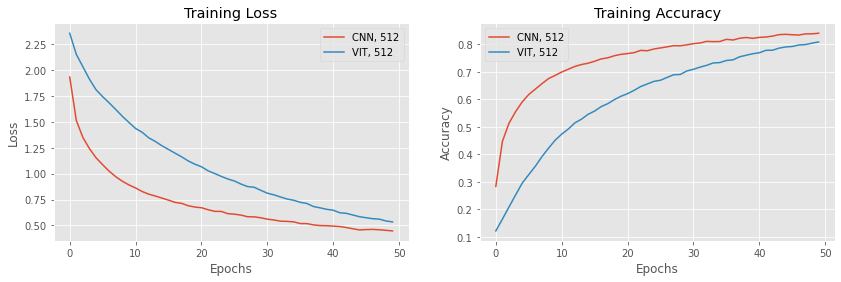

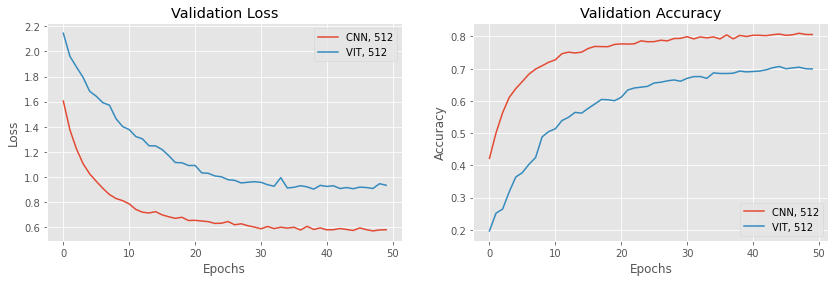

In [16]:
legends = ['CNN, 512', 'VIT, 512']
histories = [history_cnn_bs512, history_vit_bs512]

plot([i.history['loss'] for i in histories], 
     [i.history['sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Training Loss', 'Training Accuracy'])
plot([i.history['val_loss'] for i in histories], 
     [i.history['val_sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Validation Loss', 'Validation Accuracy'])